# SUALBSP-I: Parser und Gurobi-Modell
Dieses Notebook lädt `.alb`-Instanzen und baut ein Gurobi-Modell zur Minimierung der Stationsanzahl (Type-I).
Es nutzt die in den Dataset-Dateien vorhandenen Vorwärts- und Rückwärts-Rüstzeiten.

In [76]:
from __future__ import annotations

from dataclasses import dataclass
from pathlib import Path
from typing import Dict, Iterable, List, Optional, Tuple

import gurobipy as gp
from gurobipy import GRB

import matplotlib.pyplot as plt

In [77]:
@dataclass
class SUALBInstance:
    n_tasks: int
    cycle_time: int
    task_times: Dict[int, int]
    precedences: List[Tuple[int, int]]
    setup_forward: Dict[Tuple[int, int], int]
    setup_backward: Dict[Tuple[int, int], int]


def _parse_section(lines: Iterable[str]) -> Dict[str, List[str]]:
    sections: Dict[str, List[str]] = {}
    current = None
    for raw in lines:
        line = raw.strip()
        if not line:
            continue
        if line.startswith("<") and line.endswith(">"):
            current = line.strip("<>").strip()
            sections[current] = []
            continue
        if current is None:
            continue
        sections[current].append(line)
    return sections


def parse_alb_file(path: Path) -> SUALBInstance:

    sections = _parse_section(path.read_text().splitlines())

    n_tasks = int(sections["number of tasks"][0])
    cycle_time = int(sections["cycle time"][0])

    task_times: Dict[int, int] = {}
    for entry in sections["task times"]:
        task, duration = entry.split()
        task_times[int(task)] = int(duration)

    precedences: List[Tuple[int, int]] = []
    for entry in sections["precedence relations"]:
        i, j = entry.split(",")
        precedences.append((int(i), int(j)))

    setup_forward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times forward", []):
        i, rest = entry.split(",")
        j, t = rest.split(":")
        setup_forward[(int(i), int(j))] = int(t)

    setup_backward: Dict[Tuple[int, int], int] = {}
    for entry in sections.get("setup times backward", []):
        i, rest = entry.split(",")
        j, t = rest.split(":")
        setup_backward[(int(i), int(j))] = int(t)

    return SUALBInstance(
        n_tasks=n_tasks,
        cycle_time=cycle_time,
        task_times=task_times,
        precedences=precedences,
        setup_forward=setup_forward,
        setup_backward=setup_backward,
    )


In [78]:
# Beispiel: Instanz parsen (ohne Optimierung)
instance_path = Path('DataSets/MiniSet.alb')
instance = parse_alb_file(instance_path)
print(f'Aufgaben: {instance.n_tasks}, Cycle time: {instance.cycle_time}')
print(f'Task-Times: {len(instance.task_times)} Einträge')
print(f'Präzedenzkanten: {len(instance.precedences)}')
print(f'Forward-Setups: {len(instance.setup_forward)}, Backward-Setups: {len(instance.setup_backward)}')

# optional: variable to limit number of stations in the model
max_stations = None

Aufgaben: 10, Cycle time: 25
Task-Times: 10 Einträge
Präzedenzkanten: 9
Forward-Setups: 24, Backward-Setups: 24


In [79]:
tasks = list(instance.task_times.keys()); n = instance.n_tasks; cycle = instance.cycle_time
ub_stations = max_stations or n; stations = list(range(1, ub_stations + 1))

model = gp.Model("SUALBSP-I")

x = model.addVars(tasks, stations, vtype=GRB.BINARY, name="x")
u = model.addVars(stations, vtype=GRB.BINARY, name="u")
z = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="z")
f = model.addVars(tasks, stations, vtype=GRB.BINARY, name="first")
l = model.addVars(tasks, stations, vtype=GRB.BINARY, name="last")
b = model.addVars(tasks, tasks, stations, vtype=GRB.BINARY, name="backward")
p = model.addVars(tasks, stations, vtype=GRB.INTEGER, lb=1, ub=n, name="pos")

model.addConstrs((x.sum(i, "*") == 1 for i in tasks), name="assign_once")
model.addConstrs((x.sum("*", k) <= n * u[k] for k in stations), name="use_station")

model.addConstrs((f.sum("*", k) == u[k] for k in stations), name="one_first_per_station")
model.addConstrs((l.sum("*", k) == u[k] for k in stations), name="one_last_per_station")
model.addConstrs((f[i, k] <= x[i, k] for i in tasks for k in stations), name="first_only_if_assigned")
model.addConstrs((l[i, k] <= x[i, k] for i in tasks for k in stations), name="last_only_if_assigned")

model.addConstrs((z[i, j, k] <= x[i, k] for i in tasks for j in tasks for k in stations), name="order_only_if_assigned_i")
model.addConstrs((z[i, j, k] <= x[j, k] for i in tasks for j in tasks for k in stations), name="order_only_if_assigned_j")

model.addConstrs(
    (z[i, j, k] + z[j, i, k] <= x[i, k] + x[j, k]
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_upper"
)

model.addConstrs(
    (z[i, j, k] + z[j, i, k] >= x[i, k] + x[j, k] - 1
     for i in tasks for j in tasks if i < j for k in stations),
    name="order_lower"
)

model.addConstrs(
    (p[i,k] >= 1 * f[i,k]   for i in tasks for k in stations),
    name="first_pos_lb"
)

model.addConstrs(
    (p[i,k] <= 1 + (n-1) * (1 - f[i,k]) for i in tasks for k in stations),
    name="first_pos_ub"
)

model.addConstrs(
    (p[i,k] >= n * l[i,k]   for i in tasks for k in stations),
    name="last_pos_lb"
)

model.addConstrs(
    (p[i,k] <= n + (n-1) * (1 - l[i,k]) for i in tasks for k in stations),
    name="last_pos_ub"
)



big_m = n
model.addConstrs((p[i, k] - p[j, k] + big_m * z[i, j, k] <= big_m - 1 + (1 - x[i, k]) * big_m + (1 - x[j, k]) * big_m for i in tasks for j in tasks if i != j for k in stations), name="mtz_order")

model.addConstrs((z[i, j, k] >= f[i, k] + x[j, k] - 1 for i in tasks for j in tasks if i != j for k in stations), name="first_precedes_all")
model.addConstrs((z[i, j, k] <= 1 - l[j, k] + x[i, k] for i in tasks for j in tasks if i != j for k in stations), name="last_followed_by_none")

model.addConstrs((b[i, j, k] <= l[i, k] for i in tasks for j in tasks for k in stations), name="backward_last")
model.addConstrs((b[i, j, k] <= f[j, k] for i in tasks for j in tasks for k in stations), name="backward_first")
model.addConstrs((b[i, j, k] >= l[i, k] + f[j, k] - 1 for i in tasks for j in tasks for k in stations), name="backward_iff")

station_index = {i: gp.quicksum(k * x[i, k] for k in stations) for i in tasks}
model.addConstrs((station_index[i] <= station_index[j] for i, j in instance.precedences), name="precede_station")
model.addConstrs((z[i, j, k] >= x[i, k] + x[j, k] - 1 for i, j in instance.precedences for k in stations), name="precede_order_same_station")

forward_default = 0; backward_default = 0
for k in stations:
    processing = gp.quicksum(instance.task_times[i] * x[i, k] for i in tasks)
    forward_setups = gp.quicksum(instance.setup_forward.get((i, j), forward_default) * z[i, j, k] for i in tasks for j in tasks if i != j)
    backward_setups = gp.quicksum(instance.setup_backward.get((i, j), backward_default) * b[i, j, k] for i in tasks for j in tasks)
    model.addConstr(processing + forward_setups + backward_setups <= cycle * u[k], name=f"cycle_{k}")

model.setObjective(gp.quicksum(u[k] for k in stations), GRB.MINIMIZE)


In [80]:
model.update()
model

<gurobi.Model MIP instance SUALBSP-I: 9349 constrs, 2410 vars, Parameter changes: Username=(user-defined), LicenseID=2732782>

In [81]:
model.optimize()

Gurobi Optimizer version 12.0.3 build v12.0.3rc0 (win64 - Windows 11.0 (26100.2))

CPU model: Intel(R) Core(TM) Ultra 7 256V, instruction set [SSE2|AVX|AVX2]
Thread count: 8 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 9349 rows, 2410 columns and 27170 nonzeros
Model fingerprint: 0x471cdfce
Variable types: 0 continuous, 2410 integer (2310 binary)
Coefficient statistics:
  Matrix range     [1e+00, 3e+01]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+01]
  RHS range        [1e+00, 3e+01]
Presolve removed 4920 rows and 1120 columns
Presolve time: 0.31s
Presolved: 4429 rows, 1290 columns, 12243 nonzeros
Variable types: 0 continuous, 1290 integer (1193 binary)
Found heuristic solution: objective 3.0000000
Found heuristic solution: objective 2.0000000

Root relaxation: cutoff, 407 iterations, 0.02 seconds (0.02 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incum

In [82]:
# Print results (mit korrekten Setup-Zeiten)
if model.status == GRB.OPTIMAL:
    print("Objective value (min #stations):", model.objVal)
    print("Cycle Time C:", cycle)
    print("")

    for k in stations:
        # alle Tasks auf Station k
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if not tasks_here:
            continue

        # nach Position sortieren (reale Reihenfolge)
        seq = sorted(tasks_here, key=lambda i: p[i, k].X)

        print(f"=== Station {k} ===")
        t = 0

        for idx, op in enumerate(seq):
            dur = instance.task_times[op]
            start = t
            end = t + dur

            print(f"Task {op:2d}: processing {dur:2d}  "
                  f"(start={start:3d}, end={end:3d})")

            t = end

            # forward setup zwischen op und nächstem
            if idx < len(seq) - 1:
                nxt = seq[idx + 1]
                s = instance.setup_forward.get((op, nxt), 0)

                if s > 0:
                    print(f"   → setup forward {s:2d} "
                          f"(between {op} → {nxt})")
                    t += s

        # ---------- BACKWARD (nur wenn wirklich im Modell aktiv) ----------
        sb = 0
        pair = None

        for i in tasks_here:
            for j in tasks_here:
                if b[i, j, k].X > 0.5:          # genau dieses Paar nutzt das Modell
                    sb = instance.setup_backward.get((i, j), 0)
                    pair = (i, j)
                    break
            if pair:
                break

        if sb > 0:
            print(f"   → setup backward {sb:2d} "
                  f"(between {pair[0]} → {pair[1]})")
            t += sb

        print(f"Total time on station {k}: {t}\n")

else:
    print("No solution found")


Objective value (min #stations): 2.0
Cycle Time C: 25

=== Station 9 ===
Task  8: processing  4  (start=  0, end=  4)
   → setup forward  2 (between 8 → 10)
Task 10: processing  3  (start=  6, end=  9)
Task  9: processing  6  (start=  9, end= 15)
   → setup backward  2 (between 9 → 8)
Total time on station 9: 17

=== Station 10 ===
Task  6: processing  3  (start=  0, end=  3)
Task  7: processing  2  (start=  3, end=  5)
Task  5: processing  5  (start=  5, end= 10)
Task  4: processing  4  (start= 10, end= 14)
   → setup forward  1 (between 4 → 2)
Task  2: processing  2  (start= 15, end= 17)
Task  3: processing  3  (start= 17, end= 20)
Task  1: processing  1  (start= 20, end= 21)
Total time on station 10: 21



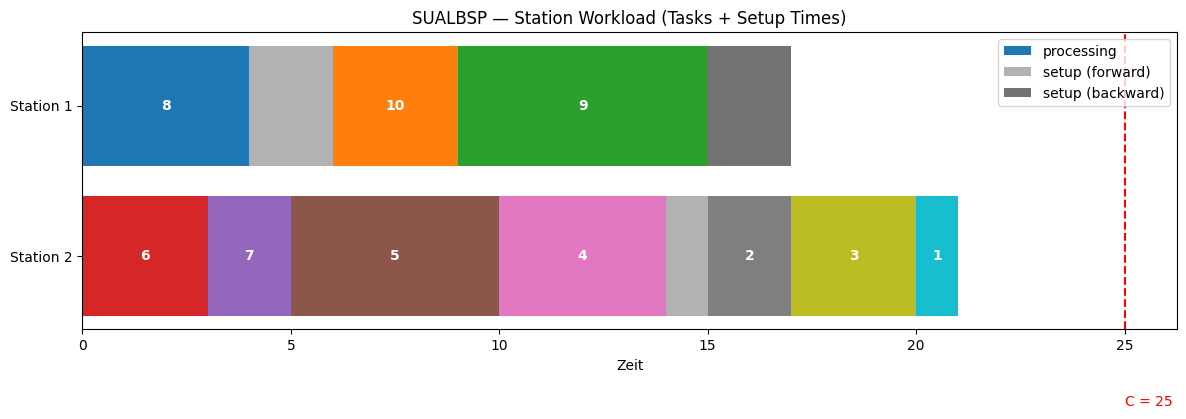

In [83]:
if model.SolCount == 0:
    print("⚠️ Keine Lösung — Plot wird übersprungen.")
else:
    # 1) Tasks je Station (geordnet per p-Variable)
    ordered_station_tasks = {}

    for k in stations:
        tasks_here = [i for i in tasks if x[i, k].X > 0.5]
        if tasks_here:
            ordered_station_tasks[k] = sorted(tasks_here, key=lambda i: p[i, k].X)

    # 2) Plot vorbereiten
    fig, ax = plt.subplots(figsize=(12, 1.2 * len(ordered_station_tasks) + 2))

    y_labels = []
    y_positions = []

    # 🔹 enumerate → Labels fangen bei 1 an
    for row, (k, seq) in enumerate(sorted(ordered_station_tasks.items())):
        y_positions.append(row)
        y_labels.append(f"Station {row + 1}")   # <<<<<< NEU: statt Station {k}

        # Startzeit auf der Station
        t = 0

        for idx, op in enumerate(seq):
            dur = instance.task_times[op]

            # ---- Task-Balken ----
            ax.barh(
                row,
                dur,
                left=t,
                label="processing" if (row == 0 and idx == 0) else None
            )

            # Task-Label
            ax.text(
                t + dur / 2,
                row,
                f"{op}",
                ha="center",
                va="center",
                color="white",
                fontsize=10,
                fontweight="bold"
            )

            t += dur

            # ---- Forward Setup ----
            if idx < len(seq) - 1:
                nxt = seq[idx + 1]
                s = instance.setup_forward.get((op, nxt), 0)

                if s > 0:
                    ax.barh(
                        row,
                        s,
                        left=t,
                        color="gray",
                        alpha=0.6,
                        label="setup (forward)" if (row == 0 and idx == 0) else None
                    )
                    t += s

        # ---- Backward Setup (letzte → erste Aufgabe) ----
        last = seq[-1]
        first = seq[0]
        sb = instance.setup_backward.get((last, first), 0)

        if sb > 0:
            ax.barh(
                row,
                sb,
                left=t,
                color="black",
                alpha=0.55,
                label="setup (backward)" if row == 0 else None
            )
            t += sb

    # Zykluszeit-Linie
    ax.axvline(cycle, linestyle="--", linewidth=1.5, color="red")
    ax.text(cycle, len(ordered_station_tasks), f"C = {cycle}", color="red")

    # Achsen & Layout
    ax.set_yticks(y_positions)
    ax.set_yticklabels(y_labels)
    ax.set_xlabel("Zeit")
    ax.set_title("SUALBSP — Station Workload (Tasks + Setup Times)")
    ax.invert_yaxis()

    handles, labels = ax.get_legend_handles_labels()
    if handles:
        ax.legend()

    plt.tight_layout()
    plt.show()
